In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

from copy import deepcopy
from tqdm.notebook import tqdm

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data():
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : 10., 'ρ' : 28., 'β' : 8/3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    x = (x - min(x)) / (max(x) - min(x))
    return x

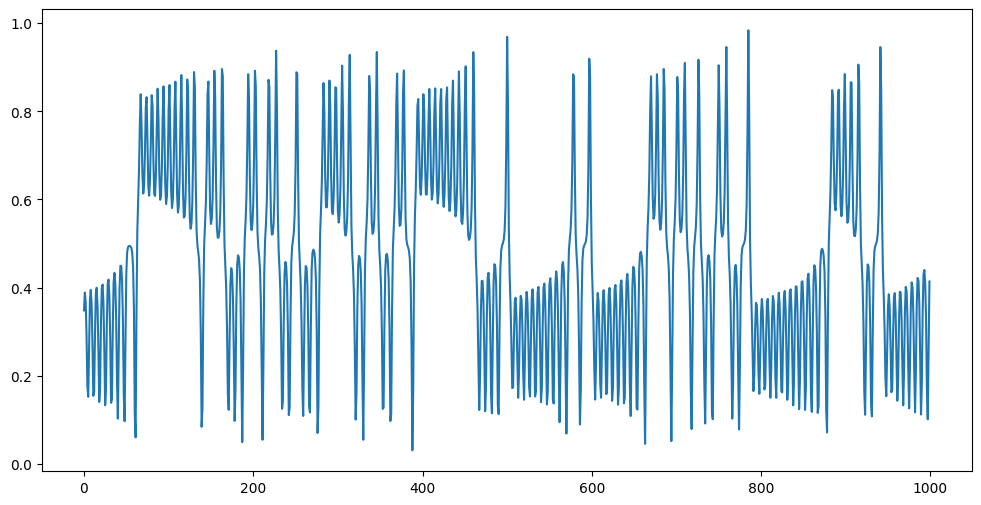

In [4]:
x = get_data()
plt.figure(figsize=(12, 6))
plt.plot(x[-1000:])
plt.show()

In [4]:
x

array([0.52126788, 0.53986791, 0.59267744, ..., 0.10142841, 0.26103432,
       0.41391076])

In [5]:
# Splitting data
points_number = x.shape[0]
train_points_number = 5000

In [6]:
# Hyper params
L = 4
K = 10
eps = 0.01
beta = 1

In [7]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

train_patterns_size = int(beta * patterns.shape[0])

# patterns = patterns[np.random.choice(np.arange(patterns.shape[0]), train_patterns_size)]

In [8]:
patterns

array([[ 0,  1,  2,  3,  4],
       [ 0,  1,  2,  3,  5],
       [ 0,  1,  2,  3,  6],
       ...,
       [ 0, 10, 20, 30, 38],
       [ 0, 10, 20, 30, 39],
       [ 0, 10, 20, 30, 40]])

In [9]:
patterns.shape

(10000, 5)

In [10]:
def sample_z_vector(pattern):
    vecs = []
    for j in range(train_points_number - pattern[-1]):
        vecs.append(x[pattern + j])
    return np.array(vecs)

In [11]:
# Calculates matrix of patterns' arrays
z_vectors_list = []
for i in range(patterns.shape[0]):
    z_vectors_list.append(sample_z_vector(patterns[i]))
# z_vectors_list = np.array(z_vectors_list)

In [12]:
z_vectors_list[0]

array([[0.52126788, 0.53986791, 0.59267744, 0.72221493, 0.92249179],
       [0.53986791, 0.59267744, 0.72221493, 0.92249179, 0.83491468],
       [0.59267744, 0.72221493, 0.92249179, 0.83491468, 0.60333675],
       ...,
       [0.52420408, 0.55961671, 0.64521052, 0.82839299, 0.92302351],
       [0.55961671, 0.64521052, 0.82839299, 0.92302351, 0.72531948],
       [0.64521052, 0.82839299, 0.92302351, 0.72531948, 0.54104469]])

In [13]:
def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [14]:
x_with_predictions = deepcopy(x)

In [15]:
predictions_based_on_actual = []
predictions_based_on_predicted = []
predicted_points_number = 50
for T in range(train_points_number, train_points_number + predicted_points_number):
    St_actual = []
    St_predicted = []
    for i in range(patterns.shape[0]):
        normalized_actial = norm(z_vectors_list[i][:, :-1] - x[(patterns[i] + T - patterns[i][-1])[:-1]])
        normalized_predicted = norm(z_vectors_list[i][:, :-1] - x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]])
        St_actual.extend(z_vectors_list[i][(normalized_actial < eps), :][:, -1])
        St_predicted.extend(z_vectors_list[i][(normalized_predicted < eps), :][:, -1])
    predicted_value_1 = np.mean(St_actual)
    predicted_value_2 = np.mean(St_predicted)
    predictions_based_on_actual.append(predicted_value_1)
    predictions_based_on_predicted.append(predicted_value_2)
    x_with_predictions[T] = predicted_value_2

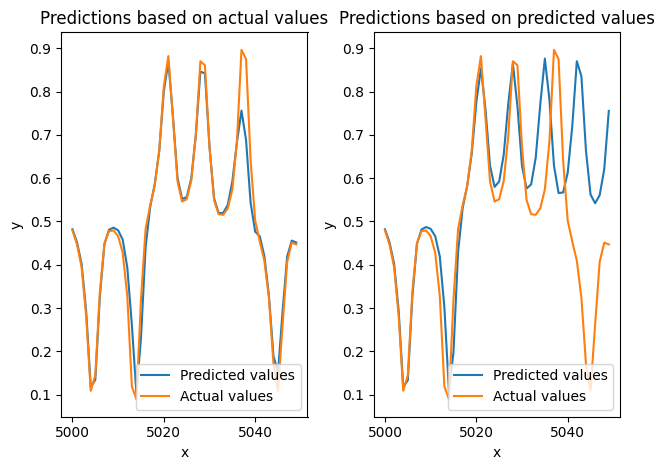

: 

In [ ]:
x_predicted = np.arange(train_points_number, train_points_number + predicted_points_number)
plt.subplot(1, 2, 1)
plt.plot(x_predicted, predictions_based_on_actual, label="Predicted values")
plt.plot(x_predicted, x[train_points_number : train_points_number + predicted_points_number], label="Actual values")
plt.title("Predictions based on actual values")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(x_predicted, predictions_based_on_predicted, label="Predicted values")
plt.plot(x_predicted, x[train_points_number : train_points_number + predicted_points_number], label="Actual values")
plt.title("Predictions based on predicted values")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()